In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow
from numpy.random import seed
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
import math

## Data scrapping

In [ ]:
import requests 
from bs4 import BeautifulSoup 
from selenium import webdriver
import time
import yfinance as yf
import missingno as mno


#List of SP500 companies
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response=requests.get(wikiurl)

soup = BeautifulSoup(response.text, 'html.parser')
sp500=soup.find('table',{'class':"wikitable"})
sp500=pd.read_html(str(sp500))
sp500=pd.DataFrame(sp500[0])
names = sp500['Symbol']
sp500.to_csv('D:/UW/Master/data/sp500.csv')

#price, volume
price = pd.DataFrame()
count = 0

for name in names.str.replace('.','-'):
    tickerData = yf.Ticker(name)
    tickerDf = tickerData.history(period='max')
    tickerDf['COMPANY'] = name
    tickerDf['SECTOR'] = sp500.loc[count, 'GICS Sector']
    price = price.append(tickerDf)
    count += 1
    print(count, str(name)+' is done. Total number: ', len(price))
    
price_sum = price[['COMPANY', 'SECTOR', 'Close']]
price_sum = price_sum.dropna()
price_sum['QUARTER'] = pd.PeriodIndex(price_sum.index, freq='Q')
price_sum = price_sum.groupby(['COMPANY','SECTOR','QUARTER'])['Close'].median()
price_sum = price_sum.reset_index()

#dividends
divd = price[['COMPANY', 'SECTOR', 'Dividends', 'Volume']]
divd = divd.dropna()
divd['QUARTER'] = pd.PeriodIndex(divd.index, freq='Q')
divd = divd.groupby(['COMPANY','SECTOR','QUARTER'])['Dividends', 'Volume'].sum()
divd = divd.reset_index()

result0 = pd.merge(divd, price_sum, on=["COMPANY", "QUARTER", 'SECTOR'])
result0 = result0.reset_index()
result0.drop('index', axis = 1, inplace = True)


#other variables
df = pd.DataFrame()
variables = ['revenue','shares-outstanding', 'net-income', 'total-assets', 'total-liabilities', 'cash-on-hand', 'total-share-holder-equity', 'number-of-employees']
headers = {
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en-US,en;q=0.8',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
}
for var in variables:
    count = 0
    print(var)
    for name in names.str.replace('-','.'):
        url = "https://www.macrotrends.net/stocks/charts/"+str(name)+"/apple/"+str(var)
        try:
            response=requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            value = soup.find_all('table',{'class':"table"})
            value = pd.read_html(str(value))
            value = pd.DataFrame(value[1])
            value.columns = ['Date', 'Amount']
            value['Variable'] = var
            value['COMPANY'] = name
            value['SECTOR'] = sp500.loc[count, 'GICS Sector']
            df = df.append(value)
            value = None
        except:
            pass
        print(count, str(name)+' is done. Total number of records: ', len(df))
        count += 1
df.to_csv('D:/UW/Master/data/df.csv') 



df_wide = df.copy()
df_wide['Amount'] = df_wide['Amount'].str.strip('$').str.replace(',', '')
df_wide['Amount'] = df_wide['Amount'].astype('float')
df_wide['Date'] = pd.to_datetime(df_wide['Date'], format = '%Y/%m/%d')
df_wide['QUARTER'] = pd.PeriodIndex(df_wide['Date'], freq='Q')
df_wide = df_wide.pivot_table(index=['Date', 'QUARTER', 'COMPANY', 'SECTOR'], columns='Variable', values=['Amount'], aggfunc='first')
df_wide = df_wide.droplevel(0, axis = 1)

result = pd.merge(df_wide, result0, on=["COMPANY", "QUARTER", 'SECTOR'])
mno.matrix(result, figsize = (20, 6))
result.isna().sum()
result = result.dropna()
#result = result.reset_index()

## Data preparation

In [543]:
data = result.copy()
#data.set_index('Unnamed: 0', inplace = True)
data = data.loc[data['QUARTER'].isin(['2019Q1', '2019Q2', '2019Q3', '2019Q4',
                                     '2020Q1', '2020Q2', '2020Q3', '2020Q4',
                                     '2021Q1', '20121Q2','2021Q3', '2021Q4'])]
data.shape

(5049, 13)

In [544]:
cols = ['QUARTER', 'SECTOR', 'cash-on-hand', 'net-income', 'revenue',
       'total-assets', 'total-liabilities', 'total-share-holder-equity',
       'Volume', 'Dividends', 'Close']
data = data[cols]
#data = data.sample(frac=1)
data

,QUARTER,SECTOR,cash-on-hand,net-income,revenue,total-assets,total-liabilities,total-share-holder-equity,Volume,Dividends,Close
25505,2019Q1,Health Care,2057.0,504.0,1284.0,8952.0,3916.0,5036.0,112942800.0,0.000,75.571022
25506,2019Q1,Information Technology,606.0,355.0,1541.0,21828.0,10243.0,11585.0,177668000.0,0.540,98.603348
25507,2019Q1,Information Technology,954.0,65.0,737.0,4729.0,4940.0,-211.0,110814300.0,0.000,153.149994
25508,2019Q1,Information Technology,3712.0,771.0,3753.0,18922.0,10713.0,8209.0,680149400.0,0.200,37.598633
25509,2019Q1,Information Technology,5093.0,471.0,5789.0,72110.0,48886.0,23224.0,189139700.0,2.650,242.695938
...,...,...,...,...,...,...,...,...,...,...,...
31051,2021Q4,Consumer Discretionary,15103.0,1337.0,11357.0,38917.0,23993.0,14924.0,374040200.0,0.305,166.670219
31052,2021Q4,Information Technology,22838.0,-1247.0,10360.0,106897.0,116555.0,-9658.0,604672000.0,0.320,94.035667
31053,2021Q4,Information Technology,1065.0,332.0,1109.0,9688.0,6568.0,3120.0,92122000.0,0.660,123.119999
31054,2021Q4,Consumer Staples,361.0,471.0,2321.0,25527.0,13981.0,11546.0,67386400.0,0.760,225.294998


In [545]:
data.dtypes

QUARTER                       object
SECTOR                        object
cash-on-hand                 float64
net-income                   float64
revenue                      float64
total-assets                 float64
total-liabilities            float64
total-share-holder-equity    float64
Volume                       float64
Dividends                    float64
Close                        float64
dtype: object

In [546]:
data.describe()

,cash-on-hand,net-income,revenue,total-assets,total-liabilities,total-share-holder-equity,Volume,Dividends,Close
count,5.049000e+03,5049.000000,5049.00000,5.049000e+03,5.049000e+03,5049.000000,5.049000e+03,5049.000000,5049.000000
mean,1.352096e+04,593.666271,6275.27352,7.666020e+04,6.050696e+04,16153.146564,3.032566e+08,0.439545,144.996347
std,8.274400e+04,1744.149156,12247.75833,2.466993e+05,2.226240e+05,31666.547292,6.201470e+08,0.804420,266.370847
min,2.000000e+00,-20070.000000,-99.00000,3.190000e+02,1.170000e+02,-18075.000000,4.573000e+05,0.000000,5.180389
25%,5.110000e+02,101.000000,1138.00000,9.524000e+03,5.648000e+03,2919.000000,6.933670e+07,0.030000,48.244781
50%,1.394000e+03,243.000000,2486.00000,2.132300e+04,1.417000e+04,6753.000000,1.331153e+08,0.338000,87.395000
75%,4.000000e+03,615.000000,5381.00000,5.440800e+04,3.846700e+04,15037.000000,2.929759e+08,0.619000,156.653435
max,1.557931e+06,28755.000000,152079.00000,3.757576e+06,3.467535e+06,290041.000000,1.223372e+10,32.500000,5101.795166


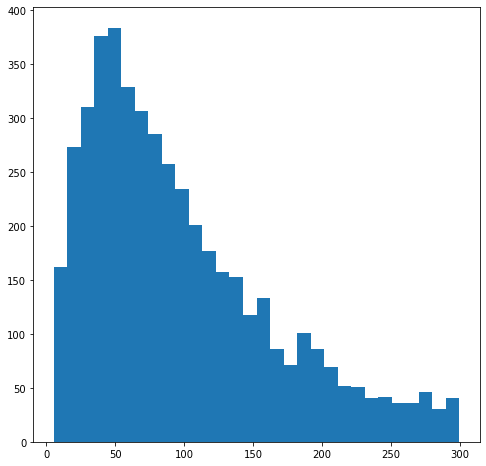

In [416]:
plt.hist(data.Close[data.Close < 300], bins=30)
plt.show()

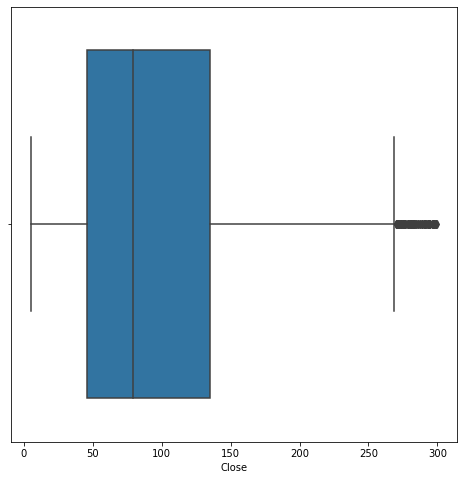

In [417]:
sns.boxplot(data.Close[data.Close < 300])

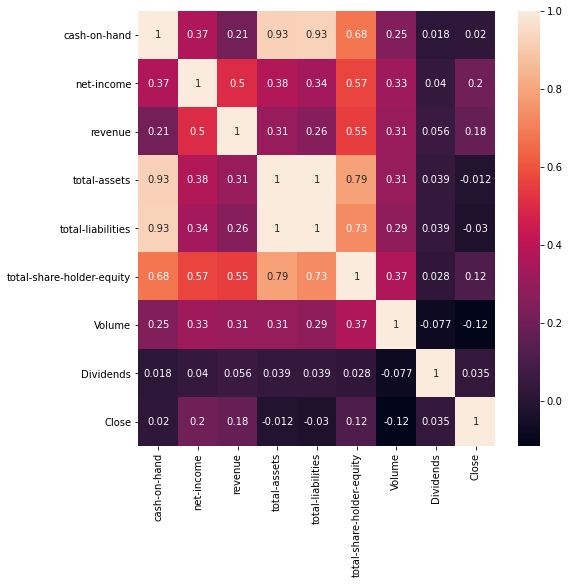

In [418]:
corr_df = pd.DataFrame(data)
corrMatrix = corr_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [422]:
scaler = MinMaxScaler()
scaler = scaler.fit(data.iloc[:,2:])
data_scaled = scaler.transform(data.iloc[:,2:])
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = cols[2:]
data_scaled.tail()

,cash-on-hand,net-income,revenue,total-assets,total-liabilities,total-share-holder-equity,Volume,Dividends,Close
5044,0.000477,0.418925,0.018439,0.008550,0.006353,0.092092,0.009536,0.000000,0.004069
5045,0.000262,0.402806,0.019326,0.007567,0.004392,0.102176,0.008552,0.017538,0.009155
5046,0.000306,0.419191,0.025023,0.021270,0.017574,0.120915,0.004612,0.001938,0.007250
5047,0.000972,0.402929,0.013287,0.003711,0.001660,0.085890,0.014440,0.000000,0.001096
5048,0.000499,0.412002,0.002083,0.001956,0.001427,0.067118,0.003941,0.032615,0.018030


In [423]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(data[['QUARTER', 'SECTOR']])
one_hot.reset_index(inplace = True)
one_hot.drop('index', axis =1, inplace = True)
one_hot.head()

,QUARTER_2019Q1,QUARTER_2019Q2,QUARTER_2019Q3,QUARTER_2019Q4,QUARTER_2020Q1,QUARTER_2020Q2,QUARTER_2020Q3,QUARTER_2020Q4,QUARTER_2021Q1,QUARTER_2021Q3,...,SECTOR_Consumer Discretionary,SECTOR_Consumer Staples,SECTOR_Energy,SECTOR_Financials,SECTOR_Health Care,SECTOR_Industrials,SECTOR_Information Technology,SECTOR_Materials,SECTOR_Real Estate,SECTOR_Utilities
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [424]:
one_hot.columns

Index(['QUARTER_2019Q1', 'QUARTER_2019Q2', 'QUARTER_2019Q3', 'QUARTER_2019Q4',
       'QUARTER_2020Q1', 'QUARTER_2020Q2', 'QUARTER_2020Q3', 'QUARTER_2020Q4',
       'QUARTER_2021Q1', 'QUARTER_2021Q3', 'QUARTER_2021Q4',
       'SECTOR_Communication Services', 'SECTOR_Consumer Discretionary',
       'SECTOR_Consumer Staples', 'SECTOR_Energy', 'SECTOR_Financials',
       'SECTOR_Health Care', 'SECTOR_Industrials',
       'SECTOR_Information Technology', 'SECTOR_Materials',
       'SECTOR_Real Estate', 'SECTOR_Utilities'],
      dtype='object')

In [425]:
# Join the encoded df
data_scaled = data_scaled.join(one_hot)
cols = ['cash-on-hand', 'net-income', 'revenue', 'total-assets', 'total-liabilities', 'total-share-holder-equity',
       'Volume', 'Dividends', 'QUARTER_2019Q1', 'QUARTER_2019Q2', 'QUARTER_2019Q3', 'QUARTER_2019Q4',
       'QUARTER_2020Q1', 'QUARTER_2020Q2', 'QUARTER_2020Q3', 'QUARTER_2020Q4',
       'QUARTER_2021Q1', 'QUARTER_2021Q3', 'QUARTER_2021Q4',
       'SECTOR_Communication Services', 'SECTOR_Consumer Discretionary',
       'SECTOR_Consumer Staples', 'SECTOR_Energy', 'SECTOR_Financials',
       'SECTOR_Health Care', 'SECTOR_Industrials',
       'SECTOR_Information Technology', 'SECTOR_Materials',
       'SECTOR_Real Estate', 'SECTOR_Utilities', 'Close']
data_scaled = data_scaled[cols]
data_scaled.head()

,cash-on-hand,net-income,revenue,total-assets,total-liabilities,total-share-holder-equity,Volume,Dividends,QUARTER_2019Q1,QUARTER_2019Q2,...,SECTOR_Consumer Staples,SECTOR_Energy,SECTOR_Financials,SECTOR_Health Care,SECTOR_Industrials,SECTOR_Information Technology,SECTOR_Materials,SECTOR_Real Estate,SECTOR_Utilities,Close
0,0.029763,0.370241,0.226176,0.070219,0.067582,0.155049,0.437430,0.004615,0,0,...,0,0,0,0,0,0,0,0,0,0.000557
1,0.000732,0.418658,0.025943,0.002421,0.001737,0.069299,0.008871,0.007846,0,0,...,0,0,0,0,0,0,0,0,0,0.020696
2,0.006563,0.425806,0.054141,0.018683,0.010194,0.172419,0.031322,0.012923,0,0,...,0,1,0,0,0,0,0,0,0,0.009636
3,0.002156,0.418884,0.014877,0.006413,0.005052,0.080668,0.004451,0.014769,0,0,...,0,0,1,0,0,0,0,0,0,0.022259
4,0.000117,0.413763,0.005099,0.001793,0.001349,0.066001,0.004417,0.007692,0,0,...,0,0,0,0,1,0,0,0,0,0.027709


In [426]:
X, y = data_scaled.iloc[:,:-1],data_scaled.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [427]:
X_test.shape

(1010, 30)

## XGBoost

In [428]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'objective': ["reg:linear"],
    'colsample_bytree': [i/10.0 for i in range(6,10)],
    'learning_rate': [i/10.0 for i in range(1,11, 2)],
    'max_depth': [i for i in range(4,10,2)],
    'n_estimators': [100, 300, 600, 1000],
    'alpha': [i for i in range(0,10,2)]
}
# Create a based model
xg_reg = xgb.XGBRegressor(verbosity = 0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xg_reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [429]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 17.5min finished


{'alpha': 0,
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': 4,
 'n_estimators': 600,
 'objective': 'reg:linear'}

In [521]:
xg_reg = xgb.XGBRegressor(alpha = 0,colsample_bytree = 0.9, learning_rate = 0.3,max_depth = 4, n_estimators = 600,
                          objective = 'reg:linear', verbosity = 0)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE XGBoost: %f" % (rmse))

RMSE XGBoost: 0.017937


In [431]:
params = {"objective":"reg:linear",'colsample_bytree': 0.7,'learning_rate': 0.5,
                'max_depth': 4, 'alpha': 4}
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical = True)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=3,metrics="rmse", as_pandas=True, seed=123)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.241344,0.000128,0.241547,0.000756
1,0.126665,0.000431,0.127286,0.001064
2,0.072118,0.000451,0.073554,0.001997
3,0.048373,0.001106,0.050265,0.002839
4,0.038336,0.001465,0.040935,0.003046
5,0.034412,0.001344,0.037272,0.002937
6,0.032788,0.001318,0.035780,0.003291
7,0.031731,0.001212,0.034855,0.003400
8,0.031136,0.001114,0.034384,0.003445
9,0.030560,0.001061,0.033953,0.003278


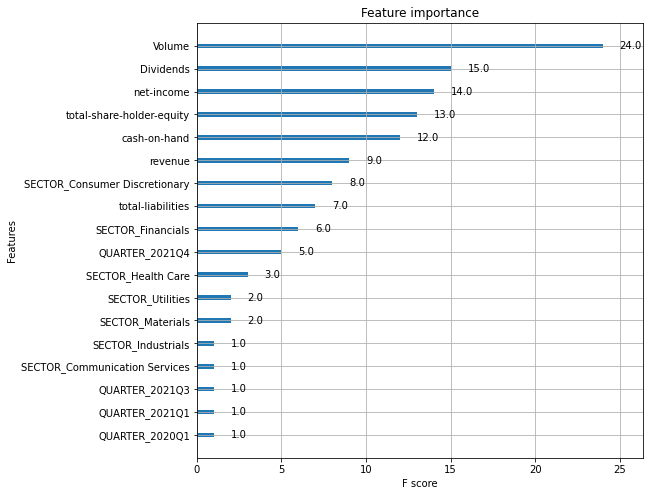

In [432]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [8,8]
plt.show()

## Random forest

In [433]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 10, 30, 50],
    'max_features': [None, 2, 3, 4],
    'min_samples_leaf': [None, 2, 4, 6],
    'n_estimators': [100, 300, 600, 1000]
}
# Create a based model
rf = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [434]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  8.8min finished


{'bootstrap': True,
 'max_depth': 30,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 1000}

In [455]:
rf = RandomForestRegressor(bootstrap = True, n_estimators = 1000, min_samples_leaf = 2, max_depth = 30,
                           random_state = 42)
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE for RandomForest: %f" % (rmse2))

RMSE for RandomForest: 0.021977


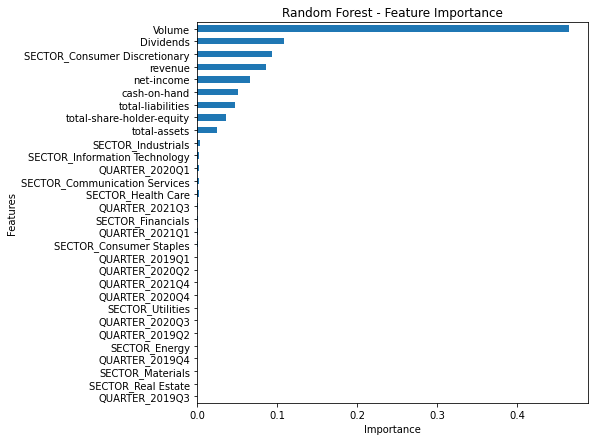

In [436]:
fea_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(7, 7), legend=None)
plt.title('Random Forest - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

## Neural network

In [437]:
n_col = X_train.shape[1]

In [ ]:
rmse_list = []
for n1 in [n_col, n_col*2, n_col*4]:
    for n2 in [n_col, n_col*2, n_col*4]:
        for batch in [4, 8, 16, 32, 64]:
            seed(321)
            tensorflow.random.set_seed(123)
            model = Sequential()
            model.add(Dense(n1, input_dim=n_col,  activation='relu'))
            model.add(Dense(n2,  activation='relu'))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam', 
                          metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
            print(n1,n2,batch)
            callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=10)
            history = model.fit(X_train, y_train, epochs=100, batch_size=batch, verbose=0, validation_data=(X_test, y_test), 
                                callbacks=[callback])
            rmse_list.append([n1, n2, batch, np.mean(history.history['val_rmse'])])

In [459]:
grid = pd.DataFrame(rmse_list, columns = ['n1', 'n2',  'batch', 'rmse'])
grid.sort_values('rmse').head()

,n1,n2,batch,rmse
17,60,30,16,0.032262
42,120,120,16,0.032812
40,120,120,4,0.033086
22,60,60,16,0.033101
1,30,30,8,0.033135


In [469]:
seed(321)
tensorflow.random.set_seed(321)
# create model
model = Sequential()
model.add(Dense(60, input_dim=n_col,  activation='relu'))
model.add(Dense(30,  activation='relu'))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
seed(321)
tensorflow.random.set_seed(321)
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=20)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, validation_data=(X_test, y_test), 
                    callbacks=[callback])

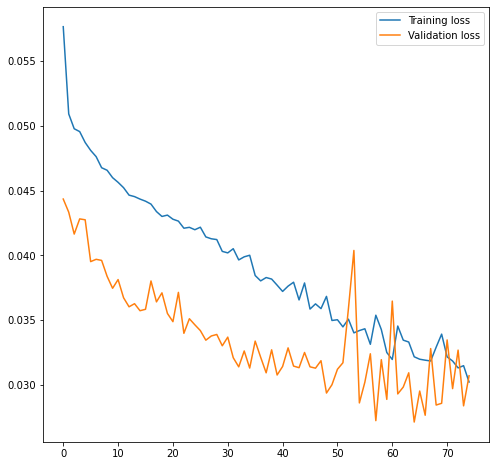

In [471]:
plt.plot(history.history['rmse'], label='Training loss')
plt.plot(history.history['val_rmse'], label='Validation loss')
plt.legend()

In [472]:
rmse3 = np.mean(history.history['val_rmse'])
rmse3

0.033692672128478686

## Combined Neural Network

In [549]:
combined = pd.DataFrame({'xgb': preds, 'rf':predictions, 'true': y_test})

In [550]:
combined

,xgb,rf,true
4039,0.011835,0.018757,0.009607
4040,-0.000726,0.001590,0.000671
4041,0.012736,0.014631,0.018597
4042,0.033476,0.027058,0.027554
4043,0.034123,0.034212,0.039463
...,...,...,...
5044,0.006442,0.012936,0.004069
5045,0.017546,0.015357,0.009155
5046,0.014940,0.021223,0.007250
5047,0.009185,0.006225,0.001096


In [445]:
n_col2 = combined.shape[1]

In [ ]:
rmse_list2 = []
for n1 in [n_col2, n_col2*2, n_col2*4]:
    for n2 in [n_col2, n_col2*2, n_col2*4]:
        for batch in [4, 8, 16, 32, 64]:
            seed(321)
            tensorflow.random.set_seed(123)
            print(n1,n2,batch)
            model2 = Sequential()
            model2.add(Dense(n1, input_dim=n_col2,  activation='relu'))
            model2.add(Dense(n2, input_dim=n_col2,  activation='relu'))
            model2.add(Dense(1))
            model2.compile(loss='mean_squared_error', optimizer='adam', 
                           metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
            callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=10)
            history2 = model2.fit(combined, y_test, epochs=100, batch_size=batch, verbose=0, validation_split=0.3, 
                                  callbacks=[callback])
            rmse_list2.append([n1, n2, batch, np.mean(history2.history['val_rmse'])])

In [475]:
grid2 = pd.DataFrame(rmse_list2, columns = ['n1', 'n2',  'batch', 'rmse'])
grid2.sort_values('rmse').head()

,n1,n2,batch,rmse
26,4,8,8,0.021302
25,4,8,4,0.021325
28,4,8,32,0.021915
27,4,8,16,0.022096
30,8,2,4,0.023231


In [536]:
seed(321)
model2 = Sequential()
model2.add(Dense(4, input_dim=n_col2,  activation='tanh'))
model2.add(Dense(8, input_dim=n_col2,  activation='tanh'))
model2.add(Dense(1))
# Compile model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
seed(321)
history2 = model2.fit(combined, y_test, epochs=100, batch_size=16, verbose=0, validation_split=0.3, callbacks=[callback])

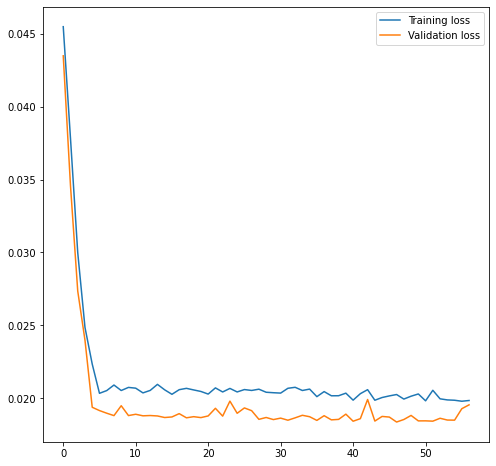

In [538]:
plt.plot(history2.history['rmse'], label='Training loss')
plt.plot(history2.history['val_rmse'], label='Validation loss')
plt.legend()

In [539]:
rmse4 = np.mean(history2.history['val_rmse'])
rmse4

0.019765711275109073

In [540]:
total_score = []
total_score.append(rmse)
total_score.append(rmse2)
total_score.append(rmse3)
total_score.append(rmse4)

In [541]:
df_total = pd.DataFrame(total_score, ['XGBoost', 'Random Forest',  'MLP', 'Combined MLP'], columns = ['RMSE'])
df_total.sort_values('RMSE')

,RMSE
XGBoost,0.017937
Combined MLP,0.019766
Random Forest,0.021977
MLP,0.033693


Text(0.5, 1.0, 'Root mean squarred error for different algorithms')

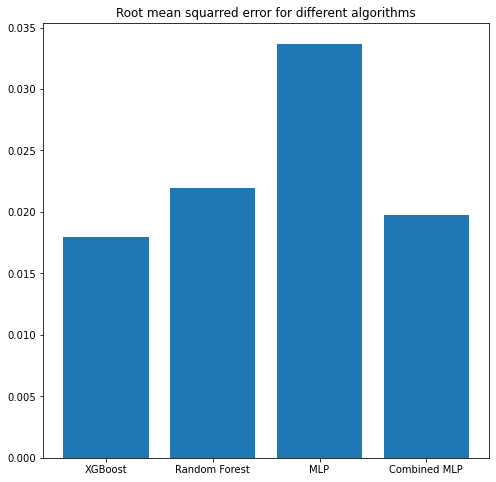

In [542]:
plt.bar(df_total.index, df_total.RMSE)
plt.title('Root mean squarred error for different algorithms')

## Summary

During analysis folowing models was used to predict Closing stock price of SP500 companies:
* XGboost
* Random Forest
* MLP neural network
* MLP neurlal network with input from XGBoost and Random Forest


With data and parameters mentioned in current project the best choise is XGboost. MLP neurlal network with input from XGBoost and Random Forest seems to suffer from little bias from Random Forest model - which RMSE is slightly higher. Common MLP model was the worst in my case. As an futher improvement some additional work can be done, for example, working with outliers and data pre-processing and better work with models tuning. 